In [1]:
from __future__ import annotations
import json
from pathlib import Path
from typing import Iterable, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv


In [2]:

import os

LIST_OF_LOG_FILES = {
    "gemini": {
        "flash":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20251110T012915Z/daf95c71075048e1b3458c3c109344fd/run_log_daf95c71075048e1b3458c3c109344fd.jsonl",
        "flash-lite":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20251022T022513Z/e2648c12511c48558c29f4c5300aa6fe/run_log_e2648c12511c48558c29f4c5300aa6fe.jsonl",
        # "pro":f"{os.getenv('PROJECT_ROOT_DIR')}/logs/run_log_9c729f3ab91c42f39b74e51fd102ebf2.jsonl", 
        },
    "qwen-7b": {
        "config_0":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260124T220209Z/d622ad5599af48dba5cf4d3435eb0545/run_log_d622ad5599af48dba5cf4d3435eb0545_with_config_0.jsonl",
        "config_1":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260124T220209Z/59ab85724c794122905a946c15baa405/run_log_59ab85724c794122905a946c15baa405_with_config_1.jsonl",
        "config_2":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260124T220209Z/b9c48dc9529b4cc4812337f5cd92f047/run_log_b9c48dc9529b4cc4812337f5cd92f047_with_config_2.jsonl",
        },
    "qwen-32b": {
        "config_0":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260129T025137Z/294cecf0e82049b58bc599cf48d0622b/run_log_294cecf0e82049b58bc599cf48d0622b_with_config_0.jsonl",
        "config_1":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260129T025137Z/3ef782858fa24527bb5a4755d31d169d/run_log_3ef782858fa24527bb5a4755d31d169d_with_config_1.jsonl",
        "config_2":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260129T025137Z/4ce329173d8e4307876d20bf4f7b5f33/run_log_4ce329173d8e4307876d20bf4f7b5f33_with_config_2.jsonl",
        },
    "deepseek-r1": {
        "config_0":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260124T212519Z/f52db77b7dc349a3bbc2615801c94643/run_log_f52db77b7dc349a3bbc2615801c94643_with_config_0.jsonl",
        "config_1":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260124T212519Z/f16e38fb574f41fb90efe88e5af39907/run_log_f16e38fb574f41fb90efe88e5af39907_with_config_1.jsonl",
        "config_2":"",
        },
    "granite": {
        "config_0":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260124T175015Z/b3f723500e5c47168ee6d851e8aee71f/run_log_b3f723500e5c47168ee6d851e8aee71f_with_config_0.jsonl",
        "config_1":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260124T175015Z/0a2b899e13b54024af5d59612a2e9802/run_log_0a2b899e13b54024af5d59612a2e9802_with_config_1.jsonl",
        "config_2":"",
        },
    "mistral": {
        "config_0":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260124T191624Z/3ea156e177624726b401d3c54a475539/run_log_3ea156e177624726b401d3c54a475539_with_config_0.jsonl",
        "config_1":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260124T191624Z/156b448efa6541378f9a1b5b46c4c6b3/run_log_156b448efa6541378f9a1b5b46c4c6b3_with_config_1.jsonl",
        "config_2":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260124T191624Z/b66bcdd98ecb466ab7734d9f65b1bd68/run_log_b66bcdd98ecb466ab7734d9f65b1bd68_with_config_2.jsonl",
        },
    "phi-4": {
        "config_0":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260125T155805Z/22aa93a4cc4f4d17ba63c2688b170f54/run_log_22aa93a4cc4f4d17ba63c2688b170f54_with_config_0.jsonl",
        "config_1":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260125T155805Z/67ac1a2443ab4ac8bfe7bba365801501/run_log_67ac1a2443ab4ac8bfe7bba365801501_with_config_1.jsonl",
        "config_2":f"{os.getenv('PROJECT_ROOT_DIR')}/results/experiment_outputs/20260125T155805Z/8cc795eb35404e8e8da0d6ec87eb7032/run_log_8cc795eb35404e8e8da0d6ec87eb7032_with_config_2.jsonl",
        },
    }

In [3]:
load_dotenv()

True

In [4]:
def compute_compile_success_rates_df(log_files_dict):
    rows = []

    for model, configs in log_files_dict.items():
        for config, log_path in configs.items():

            if not log_path:
                continue

            log_path = Path(log_path)
            if not log_path.is_file():
                print(f"⚠️ Missing log file: {log_path}")
                continue

            # Read JSONL → DataFrame
            try:
                df = pd.read_json(log_path, lines=True)
            except ValueError:
                print(f"⚠️ Failed to parse JSONL: {log_path}")
                continue

            if "compiled_success" not in df.columns:
                print(f"⚠️ 'compiled_success' not found in {log_path}")
                continue

            # Keep only True / False
            valid = df["compiled_success"].isin([True, False])
            df_valid = df.loc[valid]

            success = (df_valid["compiled_success"] == True).sum()
            failure = (df_valid["compiled_success"] == False).sum()
            null = (df["compiled_success"].isna()).sum()
            total = success + failure
            rate = success / total if total > 0 else None

            rows.append({
                "model": model,
                "config": config,
                "success": success,
                "failure": failure,
                "null": null,
                "total": total,
                "compiled_success_rate": rate,
            })

    return pd.DataFrame(rows)

In [5]:
rates_df = compute_compile_success_rates_df(LIST_OF_LOG_FILES)

# Pretty print
rates_df["compiled_success_rate_pct"] = (
    rates_df["compiled_success_rate"] * 100
).round(2)

print(rates_df)


          model      config  success  failure  null  total  \
0        gemini       flash      343        9     0    352   
1        gemini  flash-lite      160       17     0    177   
2       qwen-7b    config_0       49       35    19     84   
3       qwen-7b    config_1       65       23    18     88   
4       qwen-7b    config_2       76        0    20     76   
5      qwen-32b    config_0       54       23    26     77   
6      qwen-32b    config_1       62       15    23     77   
7      qwen-32b    config_2       10        0     3     10   
8   deepseek-r1    config_0       29       36    41     65   
9   deepseek-r1    config_1        1        5    13      6   
10      granite    config_0       24       44     0     68   
11      granite    config_1       16       61     0     77   
12      mistral    config_0       28       55     0     83   
13      mistral    config_1       36       41     0     77   
14      mistral    config_2       43        8     0     51   
15      

In [6]:
config_name_map = {
    "config_0": "Baseline",
    "config_1": "Explanation",
    "config_2": "Explanation + Block-Aware",
}

rates_df["config"] = rates_df["config"].replace(config_name_map)


In [7]:
def load_latency_dataframe(model_path_pairs, config_name):
    rows = []

    for model, path in model_path_pairs:
        if not path:
            continue

        p = Path(path)
        if not p.is_file():
            continue

        df = pd.read_json(p, lines=True)

        if df.empty:
            continue

        df = df[[
            "avg_chunk_tokens",
            "llm_latency_ms_total",
            "compiled_success",
            "total_attempts_completed"
        ]].copy()

        df["model"] = model
        df["config"] = config_name
        rows.append(df)

    if not rows:
        return pd.DataFrame()

    return pd.concat(rows, ignore_index=True)

In [8]:
config_map = {
    "Baseline": [
        ("qwen-7b", LIST_OF_LOG_FILES["qwen-7b"]["config_0"]),
        ("qwen-32b", LIST_OF_LOG_FILES["qwen-32b"]["config_0"]),
        ("mistral", LIST_OF_LOG_FILES["mistral"]["config_0"]),
        ("phi-4", LIST_OF_LOG_FILES["phi-4"]["config_0"]),
        ("granite", LIST_OF_LOG_FILES["granite"]["config_0"]),
        ("deepseek-r1", LIST_OF_LOG_FILES["deepseek-r1"]["config_0"]),
    ],
    "Explanation": [
        ("qwen-7b", LIST_OF_LOG_FILES["qwen-7b"]["config_1"]),
        ("qwen-32b", LIST_OF_LOG_FILES["qwen-32b"]["config_1"]),
        ("mistral", LIST_OF_LOG_FILES["mistral"]["config_1"]),
        ("phi-4", LIST_OF_LOG_FILES["phi-4"]["config_1"]),
        ("granite", LIST_OF_LOG_FILES["granite"]["config_1"]),
        ("deepseek-r1", LIST_OF_LOG_FILES["deepseek-r1"]["config_1"]),
    ],
    "Expl.+Block-Aware": [
        ("qwen-7b", LIST_OF_LOG_FILES["qwen-7b"]["config_2"]),
        ("qwen-32b", LIST_OF_LOG_FILES["qwen-32b"]["config_2"]),
        ("mistral", LIST_OF_LOG_FILES["mistral"]["config_2"]),
        ("phi-4", LIST_OF_LOG_FILES["phi-4"]["config_2"]),
    ],
    "proprietary": [
        ("gemini-flash", LIST_OF_LOG_FILES["gemini"]["flash"]),
        ("gemini-flash-lite", LIST_OF_LOG_FILES["gemini"]["flash-lite"]),
    ],
}


In [9]:
latency_df = pd.concat(
    [
        load_latency_dataframe(pairs, cfg)
        for cfg, pairs in config_map.items()
    ],
    ignore_index=True,
)


In [10]:
latency_df["llm_latency_min"] = latency_df["llm_latency_ms_total"] / 60000.0

In [11]:
latency_df["total_attempts_completed"]

0        4
1        8
2        2
3        3
4       17
        ..
1825     8
1826     2
1827     1
1828     2
1829     8
Name: total_attempts_completed, Length: 1830, dtype: int64

In [12]:
def boxplot_latency_by_model_and_config(
    latency_df,
    y_col="total_attempts_completed",
):
    if latency_df.empty:
        print("No data to plot.")
        return

    df = latency_df.dropna(subset=["model", "config", y_col]).copy()

    for cfg in sorted(df["config"].unique()):
        sub = df[df["config"] == cfg]
        if sub.empty:
            continue

        plt.figure(figsize=(12, 6))

        sub.boxplot(
            column=y_col,
            by="model",
            grid=False,
            showfliers=True,
        )

        # 🔒 Fixed y-axis for all except proprietary
        # if cfg != "proprietary":
        #     plt.ylim(0, 100)

        plt.title(f"LLM Total Attempts Distribution by Model ({cfg})")
        plt.suptitle("")
        plt.xlabel("Model")
        plt.ylabel("LLM Total Attempts")
        plt.xticks(rotation=30, ha="right")
        plt.grid(axis="y", alpha=0.3)

        plt.tight_layout()
        plt.show()


<Figure size 1200x600 with 0 Axes>

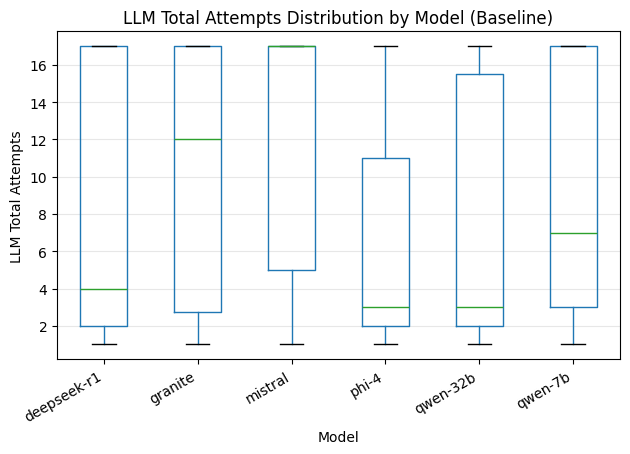

<Figure size 1200x600 with 0 Axes>

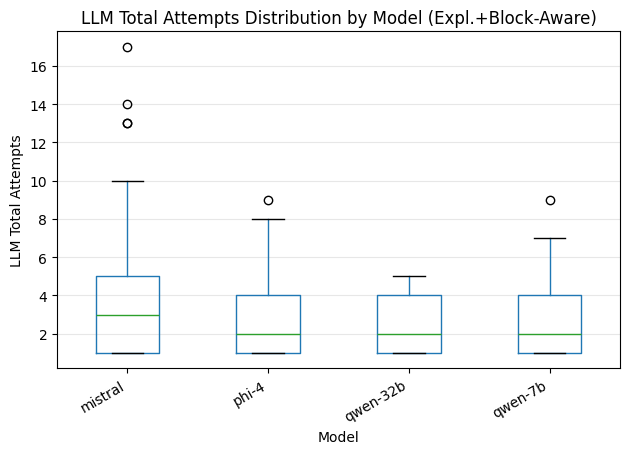

<Figure size 1200x600 with 0 Axes>

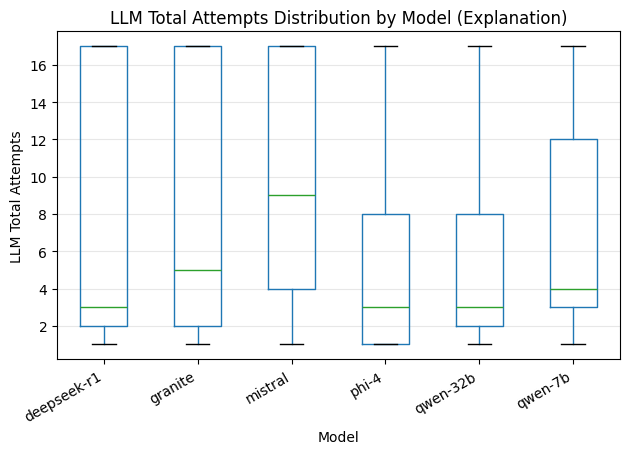

<Figure size 1200x600 with 0 Axes>

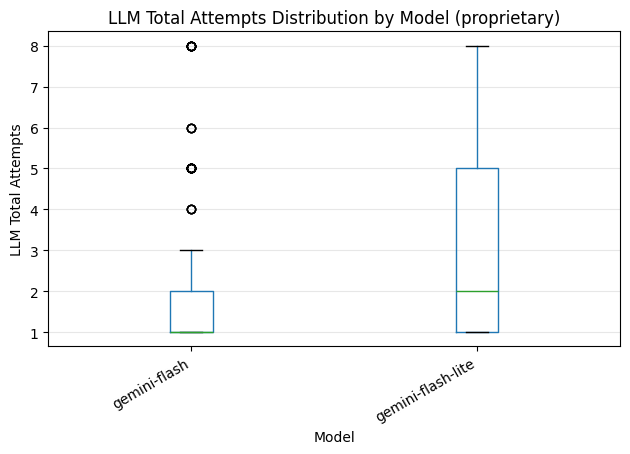

In [13]:
if latency_df.empty:
    print("No latency data available to plot.")
else:
    boxplot_latency_by_model_and_config(latency_df)
